 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 4. Tensorflow basis**
# Homework 1. face autoencoder 

### _Objective_
1. 얼굴 사진 데이터셋을 이용해 auto encoder 로 학습해 봅니다. 


╚═══════════════════════════════════════════════╝

In [0]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# 얼굴 사진 데이터셋
from sklearn.datasets import fetch_olivetti_faces

## 데이터 )  얼굴 데이터셋 



### 데이터 ) 데이터 설명

Scikit Learn library 에 내장 되어 있는 **olivetti_faces** 데이터 셋입니다.

40명의 인물이 다른 표정으로 각각 10장씩 찍은 데이터셋입니다. 


![Imgur](https://i.imgur.com/hoV87xA.png)

## \[ 문제 1 : 텐서플로우를 이용해 auto-encoder 구현하기 \]

olivetti_faces 데이터셋에 auto encoder 을 수행합니다.



### Data 불러오기


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


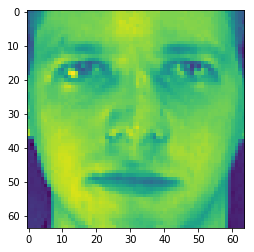

In [2]:
import tensorflow as tf
from sklearn.datasets import fetch_olivetti_faces
import random
import numpy as np
import matplotlib.pyplot as plt
import os

faces_all = fetch_olivetti_faces()
images = faces_all.images
plt.imshow(images[0:1].reshape((64,64)))
plt.show()

### Divider 만들기 


In [3]:
images = images.reshape([-1, 64 * 64])
print(images.shape)

# train data 와 Test data 을 나눕니다. 
def divide_train_test(dataset, train_ratio):
    image_size = len(dataset)
    index = int(image_size*train_ratio)
    divided1_images = dataset[0 : index, :] # [행, 열]
    divided2_images = dataset[index : , :] 
    return [divided1_images, divided2_images]

# test 이미지와 train 이미지를 나눕니다. 전체 이미지에서 train image 의 비율은 75% 입니다. 
train_images, test_images = divide_train_test(images, train_ratio=0.75)
print('face train dataset shape: {}, test dataset shape : {}'.format(train_images.shape, test_images.shape))

(400, 4096)
face train dataset shape: (300, 4096), test dataset shape : (100, 4096)


### DataProvider 만들기 


In [0]:
random.seed(0)
class DataProvider(object):
    def __init__(self, images):
        self.images = images
        self.index = 0
        
    def next_batch(self, batch_size):
        if self.index + batch_size > len(images) : # len(images) : 300
            self.index = 0
        batch_images = self.images[self.index : self.index + batch_size, :] # [행, 열]
        self.index += batch_size
        return batch_images # self.images[target_indices]

### Auto-Encoder 만들기 


In [0]:
graph = tf.Graph()
with graph.as_default() :
    # Input
    xs = tf.placeholder(dtype=tf.float32, shape=(None, 4096), name='xs') # 64 * 64 = 4096
    lr = tf.placeholder_with_default(0.01, shape=(), name='lr')
    
    # Encoder
    # layer = xs
    encode_units = [256, 256, 128]
    layer1 = tf.layers.Dense(units=encode_units[0], activation=tf.nn.relu, kernel_initializer=tf.initializers.he_normal(), name='encoding_1')(xs)
    layer2 = tf.layers.Dense(units=encode_units[1], activation=tf.nn.relu, kernel_initializer=tf.initializers.he_normal(), name='encoding_2')(layer1)
    layer3 = tf.layers.Dense(units=encode_units[2], activation=tf.nn.relu, kernel_initializer=tf.initializers.he_normal(), name='encoding_3')(layer2)
    
    # Coding
    code_unit = 128
    code = tf.layers.Dense(units=code_unit, activation=tf.nn.tanh, kernel_initializer=tf.initializers.glorot_normal(), name='code')(layer3)
    tmp = tf.zeros_like(code) ## code수정하는 부분
    code = code + tmp
    code = tf.identity(code, 'code')
    
    # Decoder
    layer = code
    decode_units = encode_units[::-1]
    
    # except code units
    layer1 = tf.layers.Dense(units=decode_units[0], activation=tf.nn.relu, kernel_initializer=tf.initializers.he_normal(), name='decoding_1')(layer)
    layer2 = tf.layers.Dense(units=decode_units[1], activation=tf.nn.relu, kernel_initializer=tf.initializers.he_normal(), name='decoding_2')(layer1)
    layer3 = tf.layers.Dense(units=decode_units[2], activation=tf.nn.relu, kernel_initializer=tf.initializers.he_normal(), name='decoding_3')(layer2)
    
    # Reconstruct
    reconstruction = tf.layers.Dense(units=4096, activation=None, kernel_initializer=tf.initializers.glorot_normal(), name='reconstruction')(layer3)
    reconstruction = tf.identity(reconstruction, 'reconstruction')
    
    # MSE Loss
    loss = tf.losses.mean_squared_error(labels=xs, predictions=reconstruction)
    
    # metric
    rmse = tf.sqrt(loss) 
    
    # Adam Optimizer 
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)

In [0]:
with graph.as_default() :
    # Session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # instance 생성
    provider = DataProvider(train_images)
    
    # Training
    batch_size = 40
    n_epoch = 1000
    n_step = int(len(train_images) / batch_size)
    learing_rate = 0.0001
    
    loss_list = []
    for e in range(n_epoch):  # 10000
        for i in range(n_step): # 7
            batch_xs = provider.next_batch(batch_size) 
            # Training
            _ = sess.run(train_op, feed_dict={ xs: batch_xs, lr:learing_rate})  # 헐 feed_dict에서 key와 값의 이름이 같으면 안된다.. lr:lr <<--- 이런 case
        
            # 폴더를 생성합니다.  
            savedir = './reconstruct_images'
            os.makedirs(savedir, exist_ok=True)    
        # epoch 이 한번 돌면 test loss 을 출력함.
        test_loss = sess.run(rmse, feed_dict={xs:test_images}) # 
        loss_list.append(test_loss)
        #print('epoch : {} , Loss : {}'.format(e, test_loss))

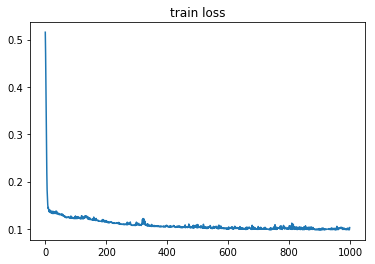

In [32]:
plt.plot(np.arange(0,n_epoch,1), loss_list)
plt.title("train loss")
plt.show()

### Change face 만들기 

학습된 코딩 부분을 변형해 얼굴이 어떻게 변화하는지 살펴 봅니다.
![Imgur](https://i.imgur.com/Ehc5Miw.png)

[0.]


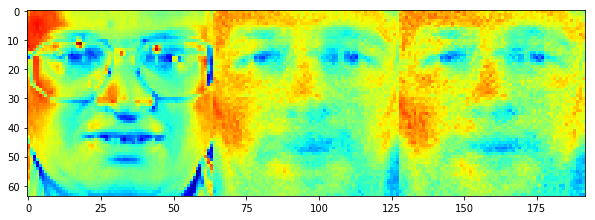

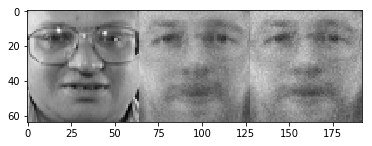

In [35]:
# code에 offset 추가
sample = test_images[1:2]
offset = np.zeros(shape=(1,128), dtype=np.float32)
print(offset[:,3])

# 복원된 이미지가 저장됩니다.
offset_images = []

# offset vector 의 element 는 모두 0 입니다. 
# offset vector 에 특정 element 에 0.1 씩 더한후 결과를 다시 코드(code)에 주입합니다.
# 코드에 주입한 후 reconstruct 된 결과를 offset_images 에 저장합니다. 
with graph.as_default() :
    offset_number = 3
    for i in np.arange(0, 1, 0.1):
        offset[:,offset_number] = i
        #recon_noise = sess.run(code, feed_dict={tmp:offset})  ### Code에 feed_dict 가능!
        recon_noise_img = sess.run(reconstruction, feed_dict={xs:sample, tmp:offset})  
        offset_images.append(recon_noise_img)
    
    # 이미지를 가로로 붙여 한장의 이미지로 만듭니다. 
    # 가장 왼쪽부터 original image, reconstruct image ,offset 에 0.1 씩 더해진 이미지

    plt.figure(figsize=(10,7))        
    faces = np.concatenate([np.reshape(sample, [64, 64]), np.reshape(offset_images[0], [64, 64]), np.reshape(offset_images[9], [64, 64])], axis=1)
    plt.imshow(faces, cmap='jet')
    plt.show()
    plt.imshow(faces, cmap='gray')
    plt.show()
                                   

### 자신의 얼굴 변형해보기

자신의 얼굴  auto encoder 에 넣고 복원된 결과를 확인해 봅니다. 


0.10588235294117647 0.9137254901960784 0.10768453 0.8411084


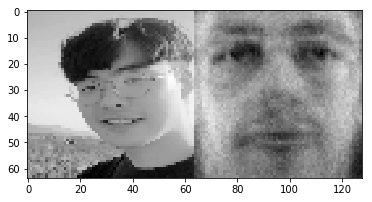

In [20]:
with graph.as_default() :
    #파일명은 myface.jpeg 로 넣어주세요. 
    
    import cv2
    # image 을 읽어오고
    my_img = cv2.imread('myface.jpeg')
    #컬러사진을 흑백사진으로 바꿉니다. 
    my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
    # 이미지 size 을 조절합니다. 
    my_img_gray=cv2.resize(my_img,(64,64))
    
    # pixel 값의 범위가 0~1 사이가 되도록 normalize 합니다. 
    my_gray = my_img_gray / 255.
    
    # 이미지를 auto encoder 에 넣을수 있도록 한줄로 핍니다. 
    my_flat = np.reshape(my_gray, [-1, 4096])
    
    # auto encoder 에서 복원된 이미지를 가져옵니다. 
    my_recon = sess.run(reconstruction, feed_dict={xs:my_flat})
    my_recon = np.reshape(my_recon, (64, 64))
    
    # original 사진과 복원된 이미지를 붙여 한장의 사진으로 만듭니다. 
    my_img_gray = my_img_gray / 255.
    faces = np.concatenate([my_img_gray, my_recon], axis=1)
    # print(my_img_gray.min(), my_img_gray.max(), my_recon.min(), my_recon.max())
    plt.imshow(faces, cmap='gray')

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---